## Imports

In [71]:
# Gina Mazza

import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import seaborn as sb
import pandas as pd

This specific notebook focuses on using MCMC methods to determine the coefficients of a polynomial.  In other words, today we seek to perform [Bayesian linear regression](https://en.wikipedia.org/wiki/Bayesian_linear_regression) using two different MCMC algorithms discussed in class, Metropolis-Hastings (MH), and Hybrid Monte-Carlo (HMC).  The former is considered the standard for MCMC algorithms and is often the basis upon which other MCMC algorithms have been developed.  Specifically here, HMC is relevant due to its utilization of gradients, which feature prominently in Neural Networks.  As such, HMC is particuluarly suited to adoption in machine learning problems.

## Data Generation

The function below generates points from a polynomial of a specified order.  The coefficients of this polynomial are chosen randomly between -10 and 10, and will be the features in the MCMC models experimented with.  The function returns both the point values, for plotting and training within the later MCMC models, and the generated coefficients for comparison to the results of the MCMC models.

In [72]:
#generate data from a polynomial with random gaussian noise
def curve_gen(x,order,sigma_obs):
  coeffs = []
  #generate curve
  return_val = 0
  for exp in range(order+1):
    coeff = np.random.rand()*2 - 1
    coeffs.append(coeff) #store for checking results against later
    return_val += (coeff*(x**exp))

  #add randomness
  for i in range(len(return_val)):
    return_val[i] += np.random.normal(scale=sigma_obs)
  return return_val,coeffs

Below the order of the polynomial and number of points plotted can be chosen.  After this the function $\tt{curve\_gen}$ defined above is called and the data for later experimentation generated.  The coefficients are saved in the variable $\tt{act\_coeffs}$ for later comparison.  Note too that a seed is given to numpy to enable reproducability.  This line may be removed if a different result is desired.

[-0.250919762305275, 0.9014286128198323]


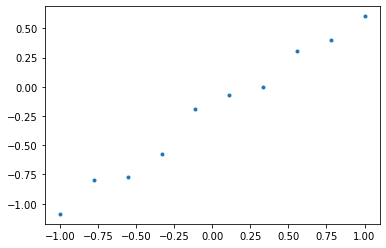

In [107]:
#for reproducability
np.random.seed(42)


# The order of the polynomial
order = 1

# The number of data points to simulate
num_pts = 10

# The x locations
x = np.linspace(-1,1,num_pts)

# The observation noise
sigma_obs = 0.1

y,act_coeffs = curve_gen(x,order,sigma_obs)

print(act_coeffs)

plt.plot(x,y,'.')
plt.show()

## Bayesian Functions
Here functions are defined for the calculation of the posterior distribution.  In particular we need both the prior and the likelihood for the calculation of the posterior.  According to Bayes' theorem, knowing these two terms along with the evidence (i.e. probability of the specific data being chosen) is all that is needed to calculate the posterior.  Bayes' theorem according to the variables defined in this document is presented below.

$$p(\beta|X,Y) = \cfrac{p(Y|X,𝜷)p(𝜷)}{p(Y|X)}$$

**Question: Why is there no equation for the evidence below?  Why is it not needed with MCMC methods?**

**Answer: Using our equation we compare both the trial point and the current point. We're comparing the two points which differ in parameters. The parameters are not part of the evidence so when we compare two points with the same denominator it's the same as comparing the the two options without the denominator (evidence).** 

With linear regression (not only Bayesian linear regression), it's often useful to calculate a mathematical object known as the design matrix.

A general polynomial curve of order $i$ can be constructed as below, where $\beta_i$ is the coefficient on $x^i$.  Note that $\beta_0$ is the y-intercept.

$$y = \sum_{i=0}^i\beta_ix^i$$

Rather than using a sum, this equality can be equivalently written using vector multiplication.

$$y = 𝝓^T𝜷$$

$$𝝓 = \begin{pmatrix}
x^0 \\
x^1 \\
\vdots\\
x^i
\end{pmatrix} = 
\begin{pmatrix}
1 \\
x^1 \\
\vdots\\
x^i
\end{pmatrix}, 
𝜷 = \begin{pmatrix}
\beta_0 \\
\beta_1 \\
\vdots\\
\beta_i
\end{pmatrix}$$

In the case of multiple datapoints the vector $𝝓$ becomes the design matrix $𝜱$.

$$
𝜱 = 
\begin{pmatrix}
1 & x_0^1 & . . . & x_0^i\\
1 & x_1^1 & . . . & x_1^i\\
\vdots & \vdots & \ddots & \vdots\\
1 & x_i^1 & . . . & x_i^i
\end{pmatrix}
$$

Therefore, $Y = 𝜱𝜷$ in the case of multiple data points.  It is left to the student to write the function $\tt{design\_mat}$, which is intended to return a design matrix.  As well, the return function for the likelihood is left empty.  This needs to return the likelihood of $Y$ given $𝜷$ and $X$.  As a hint, it's useful to consult both the other functions compelted below as well as other online sources.  [This](https://alpopkes.com/posts/machine_learning/bayesian_linear_regression/) page, [this](https://letianzj.github.io/mcmc-linear-regression.html) page, and [this](https://letianzj.github.io/bayesian-linear-regression.html) page are recommended.  (Note: the design matrix is sometimes referred to as a Vandermond matrix; check out the numpy function vander).  

In [74]:
def design_mat(x, order):
    #TODO: Write the function which will return the design matrix.
    d_mat = np.ones((len(x), order))
    for i in range(len(x)):       # 20
        for j in range(order):    # 5
            d_mat[i][j] = x[i]**j
    return d_mat

data = np.linspace(0, 10, 20)


# print(design_mat(data, 5))

Now, we need to specify our models of the likelihood and prior distribution.  For the likelihood, you should use 
$$
P(Y|X,\beta) = \prod_{i=1}^n \frac{1}{\sigma \sqrt{2\pi}} \exp{-\frac{1}{2} \left( \frac{Y_i - X_i \beta}{\sigma} \right)^2},
$$
which has the logarithm
$$
\log P(Y|X,\beta) = -\frac{n}{2}(\ln(2\pi\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^n (Y_i - X_i \beta)^2
$$
Note that this is just a simple sum of squares (with some extra constants).

For the prior, you should also assume that the parameters $\beta$ are, a priori, normally distributed with zero mean and given prior standard deviation $\sigma^2_{prior}$ 
$$
\log P(\beta_i) = -\frac{1}{2}(\ln(2\pi\sigma^2_{prior,i}) - \frac{1}{2\sigma^2_{prior,i}} \beta_i^2 .
$$
You might be able to convince yourself that this looks rather like L2 regularization.

Next, implement functions that accept $X$, $Y$, and $\beta$ and evaluate the log-likelihood, log-prior, and log-posterior (up to a constant of proportionality).  

In [75]:
n = len(x) #?

# y == design_mat?
def log_likelihood(beta,x,y,sigma_obs):

#     intercept + slope(x) vector valued set of predictions
    y_pred = beta[0] + beta[1]*x
 
    log_like = -(n/2 * (np.log(2*np.pi*sigma_obs**2))) - ((1/(2*sigma_obs**2)) * np.sum((y_pred - y)**2))
    return log_like

def log_prior(beta,sigma_prior):
    log_p = -((1/2) * np.sum((np.log(2 * np.pi * sigma_prior**2)))) - (np.sum(beta**2/(2*sigma_prior**2))) 
    return log_p

def log_posterior(beta,x,y,sigma_obs,sigma_prior):
  log_like = log_likelihood(beta,x,y,sigma_obs)
  log_pr = log_prior(beta,sigma_prior)
  return log_like + log_pr

pseudobeta = np.array([0, 0])
sigmapseudo_prior = np.array([1, 1])
log_likelihood(pseudobeta, x, y, sigma_obs)
log_posterior(pseudobeta,x,y,sigma_obs,sigmapseudo_prior)

## Strongly suggest doing some unit testing here!

-158.83880625395525

## The Algorithms!

With the Bayesian definitions above it's now time to define our algorithms.  The task today is to implement the Metropolis-Hastings algoirthm.  As a bonus you can try to implement Hybrid Monte-Carlo.  Very little code is provided for you.  While I was implementing these, the best source was the pseudo-code from the paper, followed closely by the links provided above.  However, if you get stuck feel free to ask one of us in class or take a look at the key provided!

**Question: Refer to Figure 5 in the paper, specifically the 5th line with the minimum function.  Is it necessary to have the proposal distribution q when calculating the acceptance rate?  If so why, if not why not?**

In [89]:
# x = 0                                                            # define a starting point/current state

#TODO: Implement Metropolis-Hastings algorithm
def mh(order,steps=10000,stepsize=0.1):                           
  betas = [np.zeros(order+1)]                                     #initial guess
  for i in range(steps):
    if (i+1)%(steps/100) == 0:print("Step ",i+1,"/",steps,sep='') #print steps to check progress

    #get a random uniform sample, what should the bounds be?
    u = np.random.uniform(0, 1)                                   # vs. np.random.randn ?
    
    beta_star = betas[-1] + np.random.randn(2) * stepsize                              
    
    
    prob_betaStar = log_posterior(beta_star, x, y, sigma_obs, 1)
#     print(prob_betaStar)
    prob_beta = log_posterior(betas[-1], x, y, sigma_obs, 1)
#     print(prob_beta)
    acceptance = np.exp((prob_betaStar) - (prob_beta))
    print(acceptance, u)
    
    if u <= acceptance:                                           # accepted
        betaplus1 = beta_star                                     # store current x as x* for next iteration
    else:                                                         # not accepted
        betaplus1 = betas[-1]
    betas.append(betaplus1)
        
    
    
    
    #there should be a new beta proposed in here
    
    #what should the acceptance look like?
    
    
    #do we need to look at the acceptance of all features individually or together?
  return betas

Below run your implemented Metropolis-Hastings.

In [90]:
betas = mh(order)
print(betas)

1.736003279231455e-05 0.34724446166228407
0.6531721270488197 0.7635646220262063
6.02195786941164e-08 0.526123611778777
51091.66885431192 0.42158400579063615
0.0003062298770388449 0.10851718721390813
0.012326029529829505 0.25861648955893257
3.8904748196644555e-06 0.6576356228668495
3.755832124744723e-06 0.7528254699056728
390.0633456335442 0.10918017888414855
6.244266730088775e-06 0.4837068288999439
1001.3806885938873 0.42110459307716874
0.15956518898299787 0.6391725634376625
0.0010588180688194465 0.8216821559219019
6.497363548569024e-06 0.662806656559933
1.0409053027458754 0.5466683024985755
0.0007587049594651899 0.7906586612115988
0.6769666658050167 0.8489920452379168
0.07984469687930573 0.7263364677787856
0.21989567664745718 0.44806448415951383
0.32979155724923487 0.3697879475213254
1.1764130296142874 0.6715740633102042
0.048014148293476264 0.17386751605401607
0.2652387488204832 0.20372456014113338
0.7225728844816446 0.4051792446679252
0.0005060758084984349 0.9276581325323949
2.91035

1.0563256819173219e-10 0.07450246901818314
7.653499841287755 0.6677230031779133
0.9297552136434007 0.784247004040932
0.07265015600698506 0.929098860691917
0.6654896612225548 0.16158896796959077
2.2705904133301034e-12 0.027429101945957268
1.920235664515104e-07 0.043531361788017864
3.5231274787896885e-10 0.18388439268682877
3.4107852935035165e-05 0.4724227360325248
0.5641964252550477 0.44185962381062394
0.0027623243990393745 0.10013786904296851
1.5198604278861398 0.11310561265255481
0.0011330584611207932 0.9086448711192033
0.9060547601313771 0.030284192840991264
8.158314827429715e-12 0.22875643448835214
0.24850776876350544 0.915902777592101
Step 400/10000
1.4832807222338327 0.25738801408388456
1.0240968763334766 0.9651723240968167
1.9123628808658093e-05 0.08839724692162776
1.3176351331611187 0.6895984955919163
0.8563567720527807 0.2513193512859945
0.002842267451989786 0.16005231770685002
7.5799896693909e-06 0.6065938312734143
0.5603774724143347 0.5447999594558735
0.7846775895354001 0.213

0.5718091920782764 0.40666392923299355
0.00012844842667898799 0.2629262669043798
2.7178498491913117 0.13090693684737398
0.0008424501772216451 0.10425286572461434
3.818397663175834e-06 0.7133627226802297
0.002525668113976456 0.6636791693565279
1.1713074489407314 0.4086290137192832
3.7099935900404078e-09 0.2998642634334221
0.8676426468750021 0.612698947018965
0.0066597401818706825 0.7822876053772468
0.0009767051686626674 0.028818375140863495
0.00868587150762661 0.46388958712128425
7.069792174512889e-13 0.508368668460704
0.06085468180458992 0.25188499452978674
0.7949519400305483 0.7021922449640415
0.048329147016645375 0.22403964332701765
0.6660787060445096 0.8921146431684701
1.2049108676429907 0.5366103232967017
4.7069997560556674e-17 0.8859557879610646
0.1000772604020145 0.6657878190323534
0.29326211131939284 0.719921452170455
0.008470321434372699 0.9505764528988554
0.1600297576446675 0.5519360472466592
5.460993561126836e-07 0.6786702001124363
0.5680807969923957 0.5178202986532077
1.1631

0.0015624456654905554 0.4418453232570957
1.0441153402898131 0.515972596270985
0.4119299067444724 0.13937818619153886
0.028309074058814148 0.4397828384907043
2.5491871111171204e-05 0.5345273742243177
0.0013454147831602683 0.6471363822124632
0.008269120917664534 0.3141335169254049
0.006157166578374714 0.5627812274860385
2.4380694576544424 0.23548129298649134
0.03755092086070649 0.7212991459055533
0.008353513875218953 0.24630522442395608
0.7550824252461213 0.6258918106574272
0.00365295071855422 0.7081479951106119
0.6560593772158311 0.6789827729147893
9.201766915859443e-09 0.6666796402337543
0.30926973462984003 0.1907175418798268
8.768244768781064e-09 0.48173352789219914
4.825821995396936 0.5647515636282824
0.10331188497394861 0.7289882951455372
0.9595781093497315 0.23449155399649912
0.8896078290688207 0.3258797605550854
1.1969127272525466 0.8070874993507668
0.11349480868995795 0.39291806131941
1.5418644025619203e-08 0.7180030966859824
0.5936749612544345 0.2868396610330268
2.11878789547211

2.6512438875907917e-12 0.3247014354612071
0.9766758445140226 0.07189691651460406
1.0176356560241722 0.3708623272579269
0.0001222867637841668 0.38500296810510415
0.8148704545078307 0.7396065329465973
1.2686796232638222 0.8188775511367119
1.2048485137401793e-07 0.42922841153295366
Step 1400/10000
0.5117924616235522 0.8749326265741181
0.8049866728907276 0.7476395333862431
8.618402416983846e-13 0.9248168946178259
0.07380600337424983 0.009552776616969072
1.1003964555223298 0.9623060446947994
0.2466353232593871 0.05699418452026672
0.009724118151350323 0.029660743564281056
0.36661248066640484 0.12978076729942423
21.82032940066478 0.9464646154277803
0.002569929280657424 0.9466164395898741
7.476013682877733 0.44819591776743384
2.1303030740319248e-10 0.898327323304383
5.702669876380376e-06 0.44692129183683904
0.0001447372279669108 0.9279475222441557
0.010982391383786889 0.7319445357122386
1.0239679795520453 0.6668156750156945
3.612567428850444e-05 0.9926381758474568
0.35622167725549647 0.2500240

0.02214752272679464 0.7421444255511704
0.33606428349576933 0.8531840720807808
0.05171471230254939 0.06213118519788663
5.347664959085135e-05 0.17714375370537905
0.9650632562230902 0.26061702796880404
2.4402222824549153e-08 0.8044539233286228
0.12079750900585802 0.8839742987118493
0.9415983672325652 0.19829518252027967
1.249050018678359 0.04601135763141462
0.00040652720027021513 0.3421565538100264
Step 1700/10000
0.9150430260838898 0.3533161208284148
1.1585395603678013 0.6251791646752402
0.0016258814677470956 0.6456960795682218
0.3008027336030168 0.9160516313132415
2.4594585479474165e-06 0.7036078280700853
2.0992562240542948e-08 0.1472684241652119
0.016331302664628886 0.43197063449991635
1.7103148605492046e-06 0.017375963661256932
0.8673997506850767 0.4204320597017073
0.1557627030261853 0.3274587745991602
0.0002758671504639007 0.6575762515095032
0.9243322942730878 0.02855526083653037
0.5747961106851528 0.787934286442492
0.654793422109842 0.7961240546835278
8.127693707333878e-05 0.3381441

0.008676991807543074 0.8893162432490538
0.728526373947488 0.41705917357139355
0.08705442664137598 0.6751180756214514
0.7136018516002942 0.20553104276895962
1.7773229608545544 0.41278456331432434
0.8910051972520943 0.6929005605390304
0.1504932429037429 0.07882389545335
0.0011165637455379234 0.19952736629822
0.037309383677803044 0.3006786957836114
0.001567568376556033 0.6884118272820565
1.9970310525122779 0.06769566218446077
3.850875771390027e-15 0.05901664426374176
2.1715999344388153 0.5924616567788439
1.892040695467133 0.6708298304977527
5.125230855512196e-13 0.7635938636237385
0.8343483850020107 0.6089798201757071
0.00021608395314565507 0.6268452185006631
0.020663077462892112 0.11258482846627937
4.089782983236392e-10 0.4657999784979715
0.006755004780388622 0.5801430853279106
2.36010883871358e-06 0.43299668755151755
3.0320682716937185e-08 0.441308191155138
1.012347098971252 0.2385708256109662
0.09969845789802802 0.5372881862058948
0.8224699700414342 0.5700853095216198
0.982488891401345

1.0223689668681551e-05 0.11411326519726817
0.032582741159486714 0.21613064250131997
0.1475370896175735 0.72111893258
0.00024452339472738626 0.6889925394335452
0.0779578885101144 0.39716806133127835
0.45910816175740055 0.6544843906823702
1.164706738017011 0.10277056024930697
0.08728043454597079 0.5267198745638754
3.2102477714550874e-07 0.8297695830837843
1.7148297897011723e-10 0.7383732712530249
3.9796485054825966e-05 0.6690778473873946
1.0314117083801426 0.9432786045140967
0.029705701029330067 0.561380798170347
0.24916554672264213 0.9451870536778255
0.18528480109419004 0.9295472843248312
0.7766019290800753 0.2038733092321151
0.034840921054531425 0.6481003370283095
1.0092781172486198 0.9146048593892884
3.28822553617868e-10 0.51271257966419
0.11783724000899597 0.1035052314186905
0.00020065416138885828 0.47902105655297067
3.5997027215742596 0.40659286031398645
8.206812264682413e-08 0.022855769503791534
2.0245437015553895e-05 0.6544306113800963
0.0018322036686821 0.25532962440843965
0.9445

4.1625918594096725e-05 0.22819597512470113
1.3052259093349723 0.6787627158785893
0.016443089217988142 0.4223215634324846
1.0774464256314826 0.3534079797309434
1.955427305155462 0.32993240587637496
6.44536885979197e-05 0.7112523934128624
0.0011544710414144045 0.15309739464624172
0.4049094615874176 0.7612313354066401
0.006512548650360269 0.3097635283920812
0.2510276216196575 0.8129514030252077
0.0032601711896446117 0.5089874838541691
0.9281053488066167 0.9714570678762653
1.7495763836542676e-05 0.16524656699837525
0.0255513869896762 0.7706309833689707
4.2777035176993934e-08 0.8252271579653299
1.0498966011030777 0.6207054968000881
1.0139647159921363 0.6296194490394307
0.8128455948925701 0.9963574617147924
0.0006798636213712602 0.21290084101438145
0.1626182615872717 0.22252877152580608
0.27243262871657054 0.13460503451883643
0.14053732637960595 0.4165689951433751
2.507263769851713 0.1415307988516642
0.28845475992360403 0.8281932549086296
1.418507137691492 0.32102656983345357
0.0865680134000

0.5753735169640913 0.3466032317916605
4.673254051955621e-05 0.6571994867406424
0.0005525920234269686 0.3409333360226642
0.007073692581764536 0.8345415154768691
1.6444731788496378 0.8997584063217782
3.892019820029498e-06 0.03448758643196714
0.08694741333898603 0.3595650660046903
0.16192599688099119 0.12809505301456536
0.1419177955001771 0.2260710776786783
0.0006881729293983446 0.7267366689403146
4.398749169240923 0.8688321830003761
1.1759073509686877 0.268905076331891
0.0227505746526218 0.40139052015930987
0.9320108966316529 0.4203935629957981
0.9089949394587029 0.7250064381031529
0.6190755089225961 0.17038794870191631
0.003199864894824593 0.5807305288922068
6.437765894198118e-17 0.7479780687612475
0.4973528025120453 0.9357284939072696
2.5785908554259533 0.01175596472760021
Step 3100/10000
0.5773083899152001 0.2989418779304426
0.00012821388394408783 0.05085642372867716
0.080117850192334 0.9235478498385505
0.012652320304456387 0.3800685518124355
1.1563124517156136 0.03143015765021795
0.0

0.9418940182514345 0.8502487663099076
0.8364200496821452 0.8396780344607154
0.014914911689990347 0.36381139898902737
0.48038460193961197 0.5620643842375914
0.576617914838675 0.010393340327031653
0.00014922619258746727 0.785525297766573
0.4188765566249113 0.36862828188468355
3.4812909353791026 0.17486502221267386
0.021159062373384753 0.22812402526733655
0.0005227036763809311 0.09039099208220636
0.8207860499875038 0.19312028132415915
0.005592314099375212 0.3006105828711646
1.1999434004803626 0.7336239241326038
0.0007271737423104989 0.21667724665844068
0.16495359457646908 0.976023699963297
8.087218556879156e-09 0.27742316526562116
0.003749894715070626 0.19295460064818837
0.007453576481135149 0.7664040160965936
0.07204605274105501 0.1884268915567444
1.0504129335215022 0.8474280810809569
0.004459519030245073 0.1795952813996199
1.1063765423424292 0.31767311947286836
0.7926077522059958 0.2322116618922574
0.00033115912845166936 0.1680494003175237
0.0049781199250949525 0.8196976747735639
0.0120

0.05320428346491369 0.6770680714343819
0.0006264687827985037 0.9570668750624416
0.0013524559929717881 0.7540201262858824
0.8716785113979554 0.27566293241757667
3.106636282970617e-07 0.261268870997007
0.0001424967960548481 0.000979133676900057
1.1024507820162879 0.7736967765373128
0.4719855841158533 0.12217398405535362
0.6422442708661869 0.8868290327489984
0.01977609370517481 0.31933300554954813
1.8553710605261529 0.9220819807687256
0.8217978438756648 0.4319632356237745
3.069120638652809e-10 0.7604933151436839
0.00017737734763917105 0.6651408768987019
1.2773965362413224 0.10377414717265132
0.022351432019479266 0.1765247619471898
1.0488902068972121 0.6532723846070556
0.002505759872432948 0.05218662987238254
0.09766830751004571 0.32385455345757974
0.00754738568516176 0.8294804756134845
0.042396923545062436 0.5866036733915648
0.23707721321537395 0.8596454435976231
0.811287659900982 0.6869624373283231
0.14065474892316074 0.0032874431122135173
1.3070605000051578e-06 0.9762601805610449
0.0401

0.3536466861155294 0.5584780674655774
0.27330214030721084 0.8855687741910242
1.1123653342185088e-06 0.43358941828196784
0.26774089724959027 0.23439488583354773
0.6422078560977256 0.6480787958111967
0.011487250588599653 0.6960157443137032
0.00017698594752272437 0.2194133057923232
6.706058774241102 0.70636472744766
0.18597775647828854 0.5990328528211694
1.113427187190721 0.8221314563856932
0.683638385258868 0.8562414646201938
0.13340075759574677 0.9611146993777406
0.5622540123754348 0.42383108998226304
0.003811019164850083 0.07039559873371692
0.003126446720292509 0.927025089316699
0.1045694140157287 0.22848001477399438
0.622619567908986 0.8563279949796895
0.6807313342081753 0.8782594917866162
0.0008252348906103233 0.9098515894387857
0.04114898964677358 0.8421284385924074
0.001246848053495632 0.6387645706684082
0.012253821875720116 0.9390188292347039
0.0020731902116286707 0.5799946663830531
0.7798606466214312 0.9937468432024701
1.7051935806268115 0.4821092005934361
0.771913200818986 0.833

0.0006200297927836074 0.003051265761076505
0.4899127686222372 0.17783585805447855
6.153855311528443e-07 0.25202197472416776
2.5490495160934607e-16 0.29169889509771196
0.008258189749610755 0.5191962965129565
9.308688215771524e-05 0.7777499164424934
7.190728079965592 0.3746771131946115
0.07132083125893121 0.7964812628269693
0.3392484643043069 0.7131825316441697
0.025016626541722365 0.09202045866155228
0.060914812812641654 0.4475491530230421
0.04797526299283574 0.0016302519343888155
22.11543653745143 0.7805963884990607
0.9119420391463576 0.03032719136773432
6.719332139866804e-10 0.7954543921961897
1.233632528831409 0.22738072357593841
4.788736776154748e-05 0.2178111893760758
0.0006138035880334376 0.6866916293778726
0.021917765344722676 0.06724641835527334
0.3800690400183102 0.05729402029487285
1.6679163532396126 0.5533331789038217
0.4781119060391159 0.41208820864104323
Step 4600/10000
2.729218842132662 0.2872476302868181
0.6349416144249717 0.20900532340417532
1.2258503338969895 0.88243877

0.11980859434651994 0.06950642746649416
0.17967322957836493 0.4801609752686542
12.164697004262743 0.7824497539306405
5.506434152008579e-05 0.4195031088744642
0.3693069329311616 0.5127572822557825
0.518808749196707 0.16663932381659985
0.8487737423033721 0.03417369393925351
0.2969792569454643 0.7358778672988096
0.0021989048114418 0.6254708117859797
0.008249778025204992 0.23632258381392257
0.1260811291266502 0.41950090535964557
0.13667497740909962 0.6684817910754367
0.1102874234906315 0.9137057425616368
1.8408202255315376 0.563886033734629
0.000147599794710578 0.7408938033362336
0.03129730919524451 0.0673199655996316
0.23010197494256815 0.9534388247033142
0.2690757612476843 0.3747199567880547
2.2043610031706676e-13 0.773144451312675
8.69740545226609e-06 0.5527996748831201
0.0002481604795389806 0.40374176347725244
0.3343494497935339 0.9988332376332111
1.7581505534377016e-06 0.554159593732457
0.5966904264952588 0.5653530723355195
0.002645444441732153 0.2242521950160038
0.012980264791807144 

0.11269770717894566 0.263703685561389
9.693624801019027e-05 0.17861110137164293
0.0030796090826009847 0.605273621844026
0.875822575882332 0.313133935909371
1.0581474616846869 0.002413831340989603
1.2513072714729493e-06 0.4843608390192714
1.1064258507681808 0.8847747469561343
0.842508690281446 0.5946887667349846
3.0344109048023625e-05 0.46185333319268296
0.3989392807642798 0.19207609409662119
3.512529969350449 0.3791343614819943
0.9197676265345475 0.3107116500089122
0.11419749122571822 0.3467530428493175
7.230767445991913e-06 0.5731429339159299
0.3580129138993001 0.3859429939896616
1.0317544203934415 0.6869620862699648
0.5343438578154864 0.4889202103870368
0.5898186907679733 0.82643102275787
4.054655557473275e-06 0.2854824677387058
0.7332131195601475 0.5836191743982556
0.5339104994746218 0.6779137602409696
1.9534407589173453 0.14938544514313934
0.059630350993574 0.6365432290985148
0.027599823810437466 0.2171290353153965
0.39821701150128536 0.9211439990616742
3.99196721662513e-05 0.44932

0.04828976840885952 0.978007588716314
0.008780010324393812 0.6784446398447578
0.7228148155356002 0.4886256665033851
0.15455254247298408 0.6339470437515061
0.004818402434858478 0.7410715497781724
4.4745048957119834e-07 0.9501869716023997
1.3221360779047184 0.525612766807365
0.4713585326894134 0.19739359253811406
5.755680567452662e-10 0.8201726574240963
0.36085249554864646 0.9240543606813104
0.015445762379795646 0.7278585038662536
0.5126869233131222 0.3938746614436194
0.6028881178209161 0.9832272834305901
0.16434167646017048 0.6818756850331991
0.3601916362949406 0.7369562988174959
1.3713399907821378e-05 0.048997303446906004
2.6082981466887003 0.770303956946872
0.0009319637687325719 0.6979445366550107
0.012117811563321713 0.4349551324058273
0.6013985127730628 0.8747110253460137
1.1854043688179479 0.6195380417646209
0.9825311574277675 0.4119377067217761
8.447561358332159e-07 0.6435415049232854
0.4159346126199027 0.6465453904770071
5.1455514148191865e-20 0.6272486687156631
0.653654987921805

0.16329657860152988 0.19455607518102203
0.49832648034090016 0.621159258949184
8.405838187430291e-08 0.4233694302652896
0.0005080833804370693 0.8977623436148128
0.10050200990661286 0.7049140683315396
0.09263813361419468 0.2735694634423239
0.0013354595566256679 0.14529841815437994
0.7222384490818051 0.49945174407285575
0.3247345221602733 0.03275217653235796
4.1946185329611534e-11 0.11180060313889395
1.5057080190029172e-06 0.9262928629137313
0.0032246387290853374 0.8025913547216569
1.282333782551889 0.6402829798092562
1.0198304372104534e-07 0.46636538554509976
0.26834325256205316 0.2329078296387369
6.933869392133014 0.12601573404955524
0.7421619207605255 0.44268348662884427
0.5186250979576245 0.29445569374480185
1.9142968537448195 0.45136855374505713
0.00021707378865657448 0.08960813119207267
0.0005044173710513949 0.7834753824909472
0.570435771601448 0.27609120005272303
0.0010999260735738783 0.699504937171297
0.10079160534156015 0.4252490424941272
8.071923152335566e-11 0.779974049778931
1

1.0269043397847448 0.6871438288499359
0.6718164877302437 0.29869912872872884
0.31562243297214543 0.8340752650577078
3.693756854950887 0.7165070842141764
0.00043306858213097184 0.48636441848332257
0.0033215410372811867 0.3615240767829393
0.015802897162800783 0.6464768126899502
0.00011063718091015484 0.6966030818587089
0.574430851843822 0.9005402563215539
0.005523035361423806 0.09453305312665661
8.186472779528411e-06 0.25138233910222474
0.05943524576224036 0.7180769373595963
0.8257656830775499 0.99897597905257
1.0524420394100868 0.9399125010530999
1.4706391267135083e-05 0.27363012572656464
0.573118851342599 0.3432693571641372
3.519560857955814e-07 0.5797737217715125
0.00208617155234005 0.7373137946255321
0.08357952860019598 0.4219633662085852
1.0003009282790175e-10 0.5947598801286852
1.027811468802536 0.595561304386709
2.639543865910805e-11 0.31809389290233503
1.0754100374368728e-05 0.3114380687361009
0.009244991050381157 0.9034714123316282
0.7776812771309659 0.4507613730941342
0.1096362

0.1508108762193251 0.6685397735547454
Step 6800/10000
3.4815380779302286e-14 0.9229881705634891
0.4822542399183681 0.2781370534138141
7.908431490371486e-09 0.6221245678581746
1.1316274662252948e-11 0.9830471706266025
0.009202714032277553 0.8828092593769454
1.8088955503794963 0.6660816224263892
0.5919893889221839 0.45635788813666767
4.067415875596696e-09 0.36939021524866067
0.37460327502625423 0.9072688057691309
1.2999710857425826 0.28256168831001005
0.516210611997342 0.07298365279398589
4.9743582708221574e-05 0.3907489413103492
0.5002788869056358 0.26269345524907795
1.602039236905632 0.03563336944670348
4.799900205220665e-20 0.7274167916545567
0.5571656004466914 0.026180781903861083
1.4759646702639452e-05 0.3164091093302217
4.340038756418058 0.5843289106020738
0.6170786088631246 0.6761813652165
1.2471054055862398 0.2548792711382113
0.05002183166260023 0.7320772697280068
0.21043851897312854 0.6694923361663242
3.0239569198474566e-08 0.8834145455666162
0.3099554707726218 0.277771301166064

0.019865628819830925 0.8753974588663038
1.661222462153454e-07 0.9077991387728838
0.0002681366247582445 0.6937069050624437
0.15700240227129017 0.5117137545627662
0.7943245842847014 0.5871893412409877
1.1143404337728735 0.6451125321172891
1.2468794945362019e-05 0.5548578579442208
0.014239627737514953 0.44835574153663094
1.2540563478489202 0.4236454228552198
1.092802815089289 0.8746594728255118
1.5793465872858076e-08 0.14600538027880539
0.09655501862381215 0.37077175493803927
0.06064309779838759 0.4739288890145288
0.45616113321860846 0.8730841830021864
0.007377811033665719 0.06060863952195539
0.015415948804381867 0.3971784808104989
0.1647522548185684 0.8616898971813266
0.141673423784775 0.2592562866125554
0.0008268811282499968 0.06916559756443375
0.020214212470037324 0.8106164810003058
0.032492263494739874 0.06310012251665764
0.7837769569138411 0.14538566408763187
Step 7100/10000
1.2075441084608078 0.7843622877984587
0.8897562679135836 0.15775155727412182
0.00032224572176339626 0.76538023

0.24416224969249695 0.3219080166075575
0.05313320877893308 0.03934131405379848
2.585770892957135e-09 0.6831470953054655
1.0250378495059833 0.17139827101947192
29.53220019754341 0.026157688457715267
0.33447856818473365 0.390651926762283
0.016255384145531165 0.6976834890013829
0.24445532143133122 0.0034463651614088375
0.0023662784822981397 0.6028368073007967
1.8926412644282133 0.07574232692038851
1.2236390342499672e-17 0.5729336773976137
0.00019308438739561688 0.8231052404496533
6.520280950478431e-13 0.5224690071183405
1.0270721417657895e-14 0.900870809481329
5.487851267251763e-10 0.3379761532125142
0.027982731481195892 0.7534254860382471
2.035007256856346 0.5819260842557968
0.9931593382680679 0.8254331314598611
1.0089848867420133 0.9884946129994769
1.0417437312585096 0.7608042126344473
0.05244860756476958 0.777948628397583
1.7056776302147172e-10 0.8682142597733821
0.45853105985522424 0.6798844202269756
0.11637955563666029 0.977030298480607
0.9454800667718251 0.22115305147721154
0.103886

0.7241212341337915 0.2014911606568517
0.7388603131195539 0.15736598206170072
1.5808082406444957 0.3058517029500242
0.0014247800455452853 0.7967039290844493
1.2515428973151441 0.0071276200919007104
3.579863334557761e-07 0.4527904546142578
0.251634429999016 0.6962885548109021
0.0060701852447091345 0.13692722881153496
0.06680888262150057 0.17041398574808586
0.5052584429848836 0.3276714292783325
0.353697506684549 0.5350731698495342
1.7518664952333949 0.24321494216145978
8.318083669376073e-10 0.45706781728705737
0.13771920891553938 0.8061359310614362
6.09041503948599e-14 0.8120811131217027
1.2164872541052647e-07 0.8661758318928157
5.641223577579836e-06 0.6280873591050443
0.5317327739551868 0.10515911787021925
2.8525345597832827e-09 0.1561691277546733
0.5621821587792013 0.26247498874634556
0.0018078766985281096 0.5647414702258063
1.9669346444347553e-18 0.6742757383605031
3.5638098971964904 0.06601681606626042
0.26476861042406336 0.1737113733074691
3.6239962286358245 0.8908048192568335
1.0523

0.5330105306284155 0.5549139578808261
0.581483076578717 0.5903106756930506
0.010104305117752326 0.325928356722312
0.5143194906993824 0.4298864184141692
1.8800589039570266 0.6418044683936021
0.7445781666954118 0.41971454426462973
0.4486712551497519 0.6591042199100683
0.7697735651127132 0.8197123793973279
0.0021531803638864914 0.4290204927134368
1.179287084032792 0.3298259590083117
1.2036929433682941 0.7651947820705799
0.005088155061828111 0.4537943812923666
0.01170120806091586 0.324779868960847
0.8250352566824168 0.1279591532728208
0.008638004127365392 0.8169472402224771
0.42122492763310976 0.3766551849697328
2.566957016432396 0.2629957753981105
4.289751415389817e-10 0.355061777665305
0.11586023660206361 0.713148822220297
0.991347509314141 0.7737684835511679
0.8183203952287799 0.5240253440196163
0.038626860018701095 0.46715736971387534
0.8873935562949263 0.4352625383005754
4.62314196739127e-06 0.48749842354682804
0.4758749402362681 0.4042436529491883
0.01251536059004413 0.50573231471596

0.13806460599267917 0.3352241500467992
9.293001520507478e-05 0.9849947719029213
6.90551357450898 0.7821512143919871
0.6663400651569812 0.5448832108719035
1.444673307657151 0.4752790488315919
0.0001275945312599082 0.886956705855573
0.7233556780833336 0.28352963359486083
0.7074021285058761 0.6453034111177451
1.473125486170696e-05 0.19361553008450694
1.8087336616741452 0.5702877022583487
0.022590608299508385 0.038182606218306825
0.5817107572042284 0.5234558380679524
0.0012511252133460512 0.6948880350068986
2.0314905048576692 0.15299909191315897
0.005644325609214056 0.22017741385707634
0.9866145476306272 0.593099438200347
0.5075005636690858 0.31460311343120684
1.5504755617472226 0.9715703795219163
0.35325839068932846 0.18359823712147239
4.2523505175423086e-08 0.264545655177468
2.765343087320783 0.6882453404132697
0.2100527460121725 0.050464031446086244
4.1257554333536595e-08 0.35322509778753874
0.06567727197876132 0.918598019419543
1.2288927209920755 0.5983669561516127
2.568896209360067 0.

0.0018761972373473818 0.6931480693838076
0.04347288065731412 0.9660450740822316
0.5266593540683419 0.18368230025637244
0.6186283026169456 0.932704688513937
1.5484257124048117 0.15222910928787825
0.03470788868414378 0.22063944272482172
0.7077159311988125 0.023114605071679173
0.19457769376913336 0.8653234812577664
0.0002030223225138151 0.37342540971450533
0.8686027743938827 0.6558147224506595
0.050630223378005906 0.18569746242451535
0.004326815653336821 0.9183981849842745
1.8248582313740362 0.26225001791893554
0.0003217207782995687 0.10244421767796463
1.9033237262975232e-17 0.46192323650675804
0.1407247023670586 0.6199224069906447
0.6019600153473009 0.3370317121680766
Step 9300/10000
0.009218762663845286 0.3216307528946637
2.067805454995102 0.714397100707578
1.484597548679239 0.9449376492010593
0.0012526255597315242 0.6013619257170014
0.5115060181336833 0.7330921575882825
0.92234697185057 0.7993855566935719
0.8980690964582994 0.3656417997750937
0.003966930987285513 0.5848170808863692
1.2

18.533297530928465 0.47811500233450044
3.2048195381608615e-11 0.9063453447142307
2.3476612729825564e-10 0.9971445865253747
0.023105400180555676 0.2844294331338906
0.13622465123932895 0.6036066556496119
1.416238845669049 0.15926252244832007
0.18958177882876656 0.8709931803269093
1.1814820338706093 0.08675705910462117
7.2385887124318066e-06 0.25180715214756266
0.020908125124741838 0.4585331087280595
1.499933329286796e-14 0.0573128801268562
0.45476844849646786 0.010880112818823284
0.06132863585838519 0.34786583608849486
0.423511904532893 0.8602757601747865
0.3722840177306465 0.012005112210754287
5.573163758790221 0.5350874219497498
0.35117059076733687 0.18900366552060455
0.8645097743351962 0.5514286636609532
3.417639533358796 0.4259964172421108
0.07404046838699335 0.9106168777299414
0.003052643671845193 0.6039162954886297
6.789004041200575e-13 0.7788386091217523
0.13799766117189566 0.3740152289134424
1.0151698772416695 0.34239980557379013
1.002814248747928e-06 0.8550109273574434
0.0667813

[array([0., 0.]), array([0., 0.]), array([0., 0.]), array([0., 0.]), array([-0.05697919,  0.15189931]), array([-0.05697919,  0.15189931]), array([-0.05697919,  0.15189931]), array([-0.05697919,  0.15189931]), array([-0.05697919,  0.15189931]), array([-0.09940048,  0.17216384]), array([-0.09940048,  0.17216384]), array([-0.19757469,  0.15867682]), array([-0.19757469,  0.15867682]), array([-0.19757469,  0.15867682]), array([-0.19757469,  0.15867682]), array([-0.20045477,  0.24271181]), array([-0.20045477,  0.24271181]), array([-0.20045477,  0.24271181]), array([-0.20045477,  0.24271181]), array([-0.20045477,  0.24271181]), array([-0.20045477,  0.24271181]), array([-0.22264728,  0.23396958]), array([-0.22264728,  0.23396958]), array([-0.26955502,  0.37738988]), array([-0.27523576,  0.42712272]), array([-0.27523576,  0.42712272]), array([-0.27523576,  0.42712272]), array([-0.27696243,  0.57304035]), array([-0.14552782,  0.61331863]), array([-0.16317218,  0.66824027]), array([-0.16317218,  

Plot the results of your Metropolis-Hastings implementation.

Below is a histogram of your MCMC results along with a red line indicating the true coefficient value.

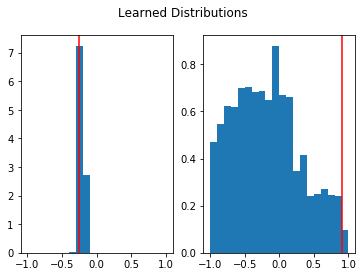

In [91]:
fig, axes = plt.subplots(1, order+1)
fig.suptitle('Learned Distributions')
for i in range(len(axes)):
  axes[i].hist(np.array(betas)[:,i],density=True,range=(-1,1),bins=20)
  axes[i].axvline(x=act_coeffs[i],color='r')

Below a function $\tt{coeff\_plot}$ is provided which takes in a series of coefficients and returns y-values for plotting.  

In [92]:
def coeff_plot(coeffs,x):
  #generate curve
  return_val = 0
  for exp in range(len(coeffs)):
    return_val += (coeffs[exp]*(x**exp))
  return return_val

First, **plot the random walk of MH algorithm throughout the feature space.** (i.e. plot the entire sequence of $\beta$ values as a scatter plot).

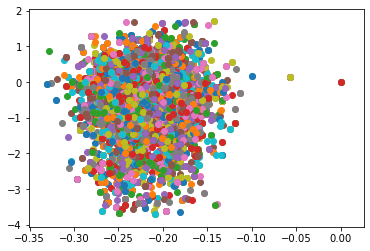

In [99]:
for beta in range(0,len(betas)-1):
  plt.scatter(betas[beta][0],betas[beta][1])

plt.show()

Next, **plot the posterior predictive distribution, i.e. make a plot of x versus y, overlaid with the predicted y for each sample of $\beta$ drawn via MCMC.

In [ ]:
plt.plot(x,y,'.')

plt.plot(x,coeff_plot(act_coeffs,x),label='Actual')

# for beta in samples, plot the regression line
for beta in enumerate(betas):
    plt.plot(x, coeff_plot(beta, x))

plt.show()



# Bonus: Hybrid MC

Before implementing HMC you will need to define the gradient of the posterior.  This is done for you.  However, the below function relies heavily on the gradient of the likelihood which is left mostly undefined.

Hint: What is the derivative of a normal distribution?  How do you account for the multiple features?  Do we already have easy access to such an object?

In [ ]:
def likelihood_grad(beta,x,y):
  #order is one less than the length of beta

  #what is the derivative of a normal distribution?
    
  #how are we going to account for gradient with respect to multiple features?

  return None

def posterior_grad(beta,x,y):
  like = likelihood_grad(beta,x,y)
  pr = prior(beta)
  return np.sum(like,axis=1)+pr

In [ ]:
#TODO: Implement Hybrid Monte-Carlo algorithm
def hmc(order, steps=10000,L=10,rho=0.1):
  betas = [np.zeros(order+1)]#initial guess
  for i in range(steps):
    if (i+1)%(steps/100) == 0:print("Step ",i+1,"/",steps,sep='')#print steps to check progress
    #now you need to sample from both a uniform and normal distribution
    
    #do you need a proposal distribution?  how are we going to get a proposed beta?
    
    #does anything special need to be done with rho?
    
    #how has the acceptance changed?
  return None

Below run your implemented Hybrid Monte-Carlo.

In [ ]:
betas = hmc(order)

Plot the random walk of HMC throughout the feature space.

In [ ]:
df = pd.DataFrame(betas)
g = sb.PairGrid(df)
g.map_offdiag(plt.scatter,s=10)
plt.show()

Compare the results of HMC to the actual coefficients used.

In [ ]:
plt.plot(x,y,'.')
plt.plot(x,coeff_plot(gen_coeffs(betas),x),label='MCMC')
plt.plot(x,coeff_plot(act_coeffs,x),label='Actual')
plt.legend()